# Fake Currency Detection

#### Import the required libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')

#### Preprocess the data

In [2]:
train_dir = r"C:\Users\krish\OneDrive\Desktop\Projects\Fake Currency Detection\dataset\train"
validation_dir = r"C:\Users\krish\OneDrive\Desktop\Projects\Fake Currency Detection\dataset\validation"

In [3]:
batch_size = 8
height = 300
width = 300

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 90,
    horizontal_flip = True,
    vertical_flip = True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (height, width),
    batch_size = batch_size
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 90,
    horizontal_flip = True,
    vertical_flip = True
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (height, width),
    batch_size = batch_size
)

Found 35 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


#### Model architecture

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

def build_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

#### Model compilation and summary

In [6]:
class_list = ['Real', 'Fake']
model = build_model(base_model, dropout=0.5, fc_layers=[1024, 1024], num_classes=len(class_list))

model.compile(
    loss = "categorical_crossentropy",
    optimizer = optimizers.SGD(learning_rate=0.000001, momentum=0.9),
    metrics = ['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 300, 300, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 306, 306, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 150, 150, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 150, 150, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 150, 150, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 152, 152, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 75, 75, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 75, 75, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 75, 75, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 75, 75, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 75, 75, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 75, 75, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 75, 75, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 75, 75, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 75, 75, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 234,355,586 (894.00 MB)

 Trainable params: 210,767,874 (804.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### Model training

In [7]:
checkpoint = ModelCheckpoint(
    "model.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=40,
    verbose=1,
    mode="auto"
)

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6221 - loss: 1.5397
Epoch 1: val_accuracy improved from -inf to 0.42857, saving model to model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 20s/step - accuracy: 0.6162 - loss: 1.5639 - val_accuracy: 0.4286 - val_loss: 1.3723
Epoch 2/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 1:07 22s/step - accuracy: 0.3750 - loss: 1.6311
Epoch 2: val_accuracy improved from 0.42857 to 0.71429, saving model to model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 20s/step - accuracy: 0.3750 - loss: 1.6311 - val_accuracy: 0.7143 - val_loss: 0.6132
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4196 - loss: 1.7301
Epoch 3: val_accuracy did not improve from 0.71429
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4393 - loss: 1.6803 - val_accuracy: 0.5714 - val_loss: 0.6716
Epoch 4/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.5000 - loss: 1.7734
Epoch 4: val_accuracy did not improve from 0.71429
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5000 - loss: 

#### Model evaluation

In [10]:
def create_classification_report(model, generator):
    true_labels = generator.classes 
    class_indices = list(generator.class_indices.keys())

    predictions = model.predict(generator, steps=generator.samples // generator.batch_size + 1)
    predicted_labels = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"The accuracy of the model is: {accuracy * 100:.2f}%\n")

    report = classification_report(true_labels, predicted_labels, target_names=class_indices)
    print(report)

create_classification_report(model, validation_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The accuracy of the model is: 57.14%

              precision    recall  f1-score   support

        Fake       0.33      0.50      0.40         2
        Real       0.75      0.60      0.67         5

    accuracy                           0.57         7
   macro avg       0.54      0.55      0.53         7
weighted avg       0.63      0.57      0.59         7



#### Visualizing accuracy and loss over epochs

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

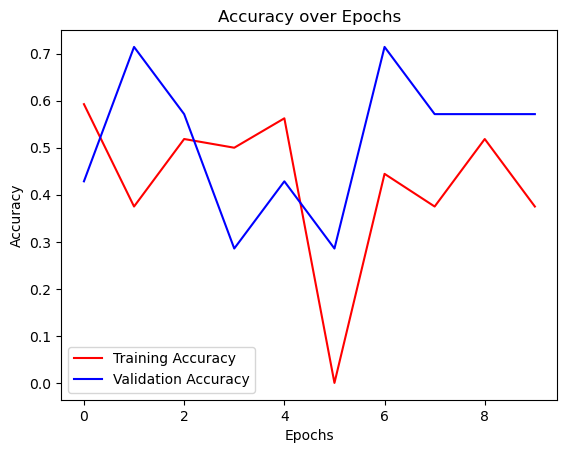

In [12]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

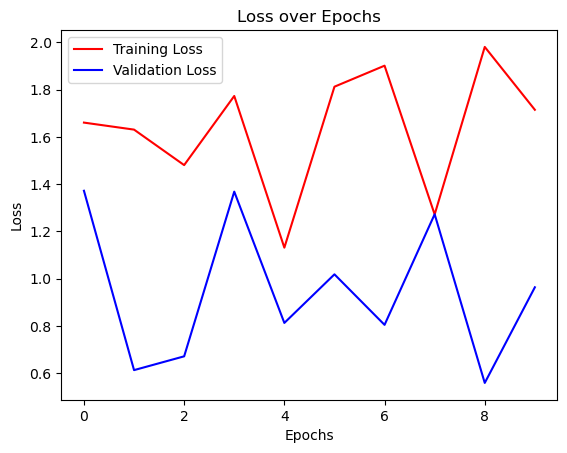

In [13]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model prediction

In [18]:
def predict_currency(image_path, model):
    img = load_img(image_path, target_size=(300, 300))  
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) 

    prediction = model.predict(img_array)
    confidence = prediction[0][0]

    if confidence < 0.5:
        label = "Real"
        confidence_score = (1 - confidence) * 100
    else:
        label = "Fake"
        confidence_score = confidence * 100

    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"Prediction: {label}\nConfidence: {confidence_score:.2f}%", color='black')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


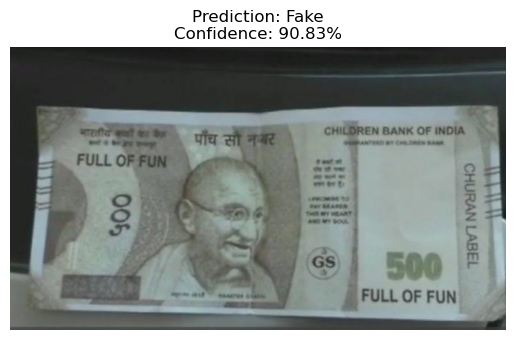

In [19]:
image_path = r"C:\Users\krish\OneDrive\Desktop\Projects\Fake Currency Detection\dataset\test\Fake.jpeg" 
predict_currency(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


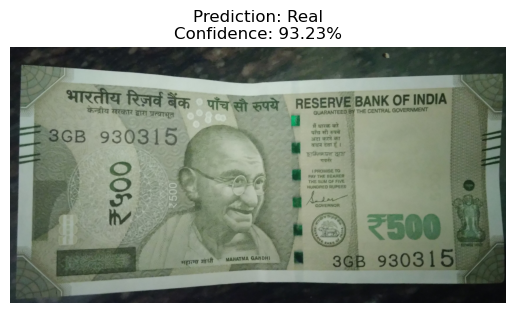

In [17]:
image_path = r"C:\Users\krish\OneDrive\Desktop\Projects\Fake Currency Detection\dataset\test\Real.jpg"  
predict_currency(image_path, model)